# Prepare data

In [1]:
import tqdm
import time
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import  metrics
 
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period

# dummy variable list            
from holidayList import hol_list

LOGNUMBER = 'e2e_seq2seq'

print('Starting the ETL process')

start_time = time.time()
df_train,df_sub = ETL_emb()
test_lengths = count_test_period(df_sub)
elapsed_time = time.time() - start_time 

print('Time taken to complete the ETL process {}'.format(elapsed_time))

forecast_ids = list(test_lengths.keys())
site_ids = list(df_sub.SiteId.unique())

# suppress pandas warnings
# do not do this in production!
pd.set_option('mode.chained_assignment', None)

submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

def preprocess_seq2seq(df_train,df_sub):
    # add train / test marker
    df_train['is_train'] = 1
    df_sub['is_train'] = 0

    # merge dataframes together
    data_df = df_train.append(df_sub)
    del df_train,df_sub
    
    # sort dataframe by site_id and timestamp 
    # so that we could easily use ar features 
    # and do indexing
    data_df['Timestamp'] = pd.to_datetime(data_df['Timestamp'] )
    data_df = data_df.sort_values(by = ['SiteId','Timestamp'])
    
    # replace non-existent temperature with base temperature
    data_df.loc[(data_df.Temperature == -1),'Temperature'] = data_df.loc[(data_df.Temperature == -1),'BaseTemperature']    
    
    
    # produce future features for temperature
    """
    print('Producing shifted future temperature features ...')
    with tqdm.tqdm(total=len(site_ids)) as pbar:
        for site_id in site_ids:
            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-1)
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-5)
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-10)
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'Temperature'].shift(-50)

            data_df.loc[data_df.SiteId == site_id, 'FT1'] = data_df.loc[data_df.SiteId == site_id, 'FT1'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT5'] = data_df.loc[data_df.SiteId == site_id, 'FT5'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT10'] = data_df.loc[data_df.SiteId == site_id, 'FT10'].fillna(method='ffill')
            data_df.loc[data_df.SiteId == site_id, 'FT50'] = data_df.loc[data_df.SiteId == site_id, 'FT50'].fillna(method='ffill')

            pbar.update(1)
    """
    
    # remove very drastic outliers 
    print('Removing drastic outliers ... ')
    with tqdm.tqdm(total=len([1964, 1968, 1969, 4325, 5276, 5536])) as pbar:
        for forecast_id in [1964, 1968, 1969, 4325, 5276, 5536]:
            data_df.loc[(data_df.ForecastId == forecast_id)
                        &(data_df.Value>10**8), 'Value'] = np.nan

            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='ffill')
            data_df.loc[data_df.ForecastId == forecast_id, 'Value'] = data_df.loc[data_df.ForecastId == forecast_id, 'Value'].fillna(method='bfill')

            pbar.update(1)
            
    return data_df

data_df = preprocess_seq2seq(df_train,df_sub)
# reset index to make sure we do not have double indexes and for easier indexing
data_df = data_df.reset_index()
del data_df['index']

# leave only the first holiday
data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
data_df = data_df.reset_index()
del data_df['index']
# fill days wo holidays with -1
data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

Starting the ETL process
Time taken to complete the ETL process 191.06669878959656


 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


In [2]:
# interpolation pipeline
# (1) find normal series
# (2) find series with all NaNs => mark as submit zeroes
# (3) use linear interpolation for series with < 0.2 NaNs
# (4) series with > 0.5 NaNs => submit averages
# (5) series with at least one test set worth of data immediately before test set => truncate train data
# (6) submit averages for the remaining series
# in the end we have
# (1) normal or interpolated series
# (2) submit zeroes
# (3) submit averages


data_df['is_null'] = 0
data_df.loc[pd.isnull(data_df.Value),'is_null'] = 1

# find normal time series
null_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].sum()
count_df = data_df[data_df.is_train == 1].groupby(['ForecastId'])['is_null'].count()
stat_df = pd.DataFrame()
stat_df['null_count'] = null_df
stat_df['count'] = count_df
stat_df['percent_null'] = stat_df['null_count']/stat_df['count']
# stat_df[stat_df.percent_null>0].percent_null.plot(kind='hist')
normal_forecast_ids = list(stat_df[(stat_df.percent_null==0)].index.values)

# all non-normal series
# that have all the train dataset values equal to NAs
submit_zeroes = list(stat_df[(stat_df.percent_null==1)].index)
# that have the majority of values equal to NAs
submit_averages = list(stat_df[(stat_df.percent_null>0.5)
                               &(stat_df.percent_null<1)].index)
# use linear interpolation for values between 0 and 0.2
linear_interpolation = list(stat_df[(stat_df.percent_null>0)
                               &(stat_df.percent_null<0.2)].index)

data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'] = data_df.loc[data_df.ForecastId.isin(linear_interpolation),'Value'].interpolate(method='linear')

try_truncating = list(stat_df[(stat_df.percent_null>0.2)
                               &(stat_df.percent_null<0.5)].index)

use_last_window = []

for forecast_id in try_truncating:
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]
    
    last_window = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==1)].iloc[-test_len * 2 - 1:]
    
    non_blank_last_window = last_window[pd.notnull(last_window.Value)].shape[0] / last_window.shape[0]
    
    if (non_blank_last_window == 1):
        use_last_window.append(forecast_id)
    else:
        submit_averages.append(forecast_id)
        
# drop non-last values for these forecast_ids
for forecast_id in use_last_window:
    
    test_len = data_df[(data_df.ForecastId==forecast_id)
                        &(data_df.is_train==0)].shape[0]

    drop_index = data_df[data_df.ForecastId == forecast_id].index[:-test_len * 3 - 1]

    data_df.drop(index=drop_index,inplace=True,axis=0)         
    
train_forecast_ids = normal_forecast_ids + linear_interpolation + use_last_window    

In [7]:
data_df[data_df.ForecastId_type == '1_day'].Holiday.unique()

array([-1.,  6.,  7.,  8.,  9., 11., 12., 15.,  0.,  1.,  2.,  3., 20.,
        4.,  5., 10., 13., 14., 16., 21., 17., 26., 22., 23., 24., 25.,
       29., 34., 35., 33., 47., 27., 53., 54., 55., 56., 48., 49., 51.,
       50., 52., 66., 67., 68., 69., 65., 61., 62., 57., 58., 59., 60.,
       74., 75., 70., 71., 72., 73., 81., 83., 84., 85., 76., 77., 78.,
       79., 92., 80., 82., 88., 90., 91.])

# Try e2e models

In [28]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# custom classes
from SDataset import S2SDataset
from ELstm import E2ELSTM,WMSELoss,E2ELSTM_day

import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import numpy as np
from math import sqrt

def train(train_loader,
          model,
          criterion,
          optimizer,
          epoch):
    losses = AverageMeter()
    # switch to train mode
    model.train()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        
        x_temp_var = torch.autograd.Variable(X_sequences_temp)
        x_meta_var = torch.autograd.Variable(X_sequences_meta)
        x_ar_var = torch.autograd.Variable(X_sequences_ar)
        y_var = torch.autograd.Variable(y_sequences)
        
        # x_temp_var = torch.autograd.Variable(X_sequences_temp.cuda(async=True))
        # x_meta_var = torch.autograd.Variable(X_sequences_meta.cuda(async=True))
        # x_ar_var = torch.autograd.Variable(X_sequences_ar.cuda(async=True))
        # y_var = torch.autograd.Variable(y_sequences.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)

        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), loss=losses))        
           
    return losses.avg

def validate(val_loader, model, criterion):
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(val_loader):
        
        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
        X_sequences_ar = X_sequences_ar.view(-1,X_sequences_ar.size(2),1).float()
        y_sequences = y_sequences.view(-1,y_sequences.size(2)).float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(X_sequences_temp) # cuda(async=True))
        x_meta_var = torch.autograd.Variable(X_sequences_meta) # cuda(async=True))
        x_ar_var = torch.autograd.Variable(X_sequences_ar) #cuda(async=True))
        y_var = torch.autograd.Variable(y_sequences) #.cuda(async=True))

        # compute output
        output = model(x_temp_var,x_meta_var,x_ar_var)
        loss = criterion(output, y_var)
        
        # measure accuracy and record loss
        losses.update(loss.data[0], X_sequences_meta.size(0))
        
        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   i, len(val_loader), loss=losses))      
            
    return losses.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from multiprocessing import Pool
from Utils import process_categorical_features
import numpy as np

class S2VDataset(data.Dataset):
    def __init__(self,
                 ):
        pass

class S2SDataset(data.Dataset):
    def __init__(self,
                 df = None,
                 series_type =  '15_mins', # '1_hour' '1_day'
                 in_sequence_len = 192,
                 out_sequence_len = 192,
                 target = 'Value',
                 mode = 'train', # train, val or test
                 split_mode = 'random', # random or left or right
                 predictors = []
                 ):
        
        
        print('Creating dataset object ...')
        self.mode = mode
        # select only one type of series
        self.df = df[df.ForecastId_type == series_type]
        
        # factorize features even further
        self.df = process_categorical_features(self.df,['Holiday','year', 'month', 'day', 'hour', 'minute','dow'])
        
        
        # order of predictors is important for CNNs
        self.predictors = predictors
        self.in_sequence_len = in_sequence_len
        self.out_sequence_len = out_sequence_len
        self.target = target
        self.mode = mode
        self.split_mode = split_mode
        
        # store the selected time series' site_ids and forecast_ids
        self.forecast_ids = list(self.df.ForecastId.unique())
        
        # do simple train test split based on forecast_ids
        self.train_f_ids, self.val_f_ids = train_test_split(self.forecast_ids,
                                                 test_size = 0.25,
                                                 random_state = 42,
                                                 )
        
        self.site_ids = list(self.df.SiteId.unique())
        
        # store the averages and std of series in dictionaries
        self.mean_dict = {}
        self.std_dict = {}

        self.__normalize__()
        
    def __produce_idx_one__(self,
                            forecast_id):

        slice_df = self.df[self.df.ForecastId == forecast_id]
        slice_df = slice_df.reset_index()

        # how many training data we have
        trainval_len = slice_df[slice_df.is_train == 1].shape[0]
        # calculate how many rolling windows we have
        trainval_window_count =  trainval_len - self.in_sequence_len - self.out_sequence_len

        slice_df_predictors = slice_df[self.predictors].values
        slice_df_targets = slice_df[self.target].values

        # idx of the trainval subset
        trainval_idx = list(slice_df[(slice_df.is_train == 1)].index)
        # idx of the test subset
        test_idx = list(slice_df[(slice_df.is_train == 0)].index)

        # we always have enough data for several rolling windows for trainval
        trainval_X_sequences_ar = np.asarray( [(slice_df_targets[trainval_idx[window:window+self.in_sequence_len]]) for window in range(0,trainval_window_count)] )
        trainval_X_sequences_meta = np.asarray( [(slice_df_predictors[trainval_idx[window : window+self.in_sequence_len+self.out_sequence_len]]) for window in range(0,trainval_window_count)] ) 
        trainval_y_sequences = np.asarray( [(slice_df_targets[trainval_idx[window+self.in_sequence_len : window+self.in_sequence_len+self.out_sequence_len]]) for window in range(0,trainval_window_count)] )

        len_diff = len(test_idx) - self.out_sequence_len
        # if the test set has standard length
        if len(test_idx) == self.out_sequence_len:
            test_X_sequences_meta = slice_df_predictors[trainval_idx[-self.in_sequence_len:] + test_idx]
            test_X_sequences_ar = slice_df_targets[trainval_idx[-self.in_sequence_len:]]
        # otherwise add several points from the train dataset
        else:
            test_X_sequences_meta = slice_df_predictors[trainval_idx[- self.out_sequence_len - len_diff:] + test_idx]
            test_X_sequences_ar = slice_df_targets[trainval_idx[- self.out_sequence_len - len_diff:]]         

        return trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,test_X_sequences_meta,test_X_sequences_ar,len_diff
    
    def __normalize__(self):
        # normalize all series, store their means and stds
        print('Normalizing features ...')
        
        self.mean_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].mean().to_dict()
        self.std_dict = self.df[self.df.is_train==1].groupby(by=['ForecastId'])['Value'].std().to_dict()
        
        # isolate series where all values are equal to one value
        # preprocess them separately
        flat_forecast_ids = [(k) for k, v in self.std_dict.items() if v == 0]
        
        # insert means for all series
        self.df['mean'] = self.df.ForecastId.apply(lambda x: self.mean_dict[x])
        # std for zero-std series is 1 by default
        self.df['std'] = 1
        # insert stds only for other series with non-zero std
        self.df.loc[~self.df['ForecastId'].isin(flat_forecast_ids),'std'] = self.df[~self.df['ForecastId'].isin(flat_forecast_ids)].ForecastId.apply(lambda x: self.std_dict[x])

        
        self.df['Value'] = (self.df['Value'] - self.df['mean']) / self.df['std']
        
        # set test set values back to 0
        self.df.loc[self.df.is_train==0,'Value'] = 0
            
    def __len__(self):
        if self.mode == 'train':
            return len(self.train_f_ids)
        elif self.mode == 'val':
            return len(self.val_f_ids)
        elif self.mode == 'test':
            # test set length is equal to the number of forecast ids
            return len(self.forecast_ids)
        elif self.mode == 'evaluate_wrmse':
            # test set length is equal to the number of forecast ids
            return len(self.forecast_ids)        

    def __getitem__(self, idx):
        if self.split_mode in ['random']:
            if self.mode == 'train':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.train_f_ids[idx])
                # sample a random index of data, e.g. 16 sequences
                # if we have a truncated sample, then pull the same sample 16 times
                if trainval_X_sequences_ar.shape[0] < 16:
                    idx = list(range(0,16))
                    trainval_X_sequences_ar = np.vstack([trainval_X_sequences_ar] * 16)
                    trainval_X_sequences_meta = np.vstack([trainval_X_sequences_meta] * 16)
                    trainval_y_sequences = np.vstack([trainval_y_sequences] * 16)
                else:
                    idx = np.random.randint(trainval_X_sequences_ar.shape[0], size=16)                
                
                return trainval_X_sequences_ar[idx],trainval_X_sequences_meta[idx],trainval_y_sequences[idx]
            elif self.mode == 'evaluate_wrmse':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.forecast_ids[idx])
                idx = -1
                # just use the last available window
                return trainval_X_sequences_ar[idx],trainval_X_sequences_meta[idx],trainval_y_sequences[idx] 
            elif self.mode == 'val':
                trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = self.__produce_idx_one__(self.val_f_ids[idx])
                # sample a random index of data, e.g. 16 sequences
                # if we have a truncated sample, then pull the same sample 16 times
                if trainval_X_sequences_ar.shape[0] < 16:
                    idx = list(range(0,16))
                    trainval_X_sequences_ar = np.vstack([trainval_X_sequences_ar] * 16)
                    trainval_X_sequences_meta = np.vstack([trainval_X_sequences_meta] * 16)
                    trainval_y_sequences = np.vstack([trainval_y_sequences] * 16)
                else:
                    idx = np.random.randint(trainval_X_sequences_ar.shape[0], size=16)                
                
                return trainval_X_sequences_ar[idx],trainval_X_sequences_meta[idx],trainval_y_sequences[idx]
            elif self.mode == 'test':
                _,_,_,test_X_sequences_meta,test_X_sequences_ar,len_diff = self.__produce_idx_one__(self.forecast_ids[idx])
                return test_X_sequences_meta,test_X_sequences_ar,len_diff
        else:
            raise ValueError('getitem method not implemented for this split mode {}'.format(self.split_mode))

In [30]:
# key params
lr = 1e-3
start_epoch = 0
epochs = 40
# 16 samples per batch
batch_size = 20
# lstm params
in_sequence_len = 192
out_sequence_len = 192
features_meta_total = 44
features_ar_total = 1
meta_hidden_layer_length = 30
ar_hidden_layer_length = 30
meta_hidden_layers = 2
ar_hidden_layers = 2
lstm_dropout = 0
# MLP model end params
# B x meta_hidden_layer_length || B x ar_hidden_layer_length => classifier_hidden_length => out_sequence_len
classifier_hidden_length = 256

In [ ]:
torch.cuda.empty_cache()

In [13]:
for i, (X_sequences_ar,X_sequences_meta,y_sequences) in enumerate(train_loader):
    
    break

In [15]:
# transform data from Batch x Window x Etc into Batch x Etc format
X_sequences_meta = X_sequences_meta.view(-1,X_sequences_meta.size(2),X_sequences_meta.size(3))
X_sequences_meta = X_sequences_meta[:,:,1:].long()

In [17]:
X_sequences_meta[:,:,5]


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     1     1  ...      1     1     1
    1     1     1  ...      1     1     1
    1     1     1  ...      1     1     1
[torch.LongTensor of size 320x60]

In [16]:
X_sequences_ar.size()

torch.Size([20, 16, 30])

In [11]:
train_dataset.tra

[3320,
 6152,
 6466,
 410,
 650,
 540,
 6151,
 6964,
 3707,
 6727,
 189,
 1905,
 3400,
 4294,
 3399,
 2358,
 3738,
 6462,
 5236,
 877,
 413,
 982,
 649,
 1390,
 6011,
 4394,
 5233,
 1534,
 6008,
 6972,
 2925,
 1319,
 4323,
 2977,
 4270,
 547,
 5229,
 5600,
 4325,
 1,
 3,
 2926,
 1529,
 6969,
 4293,
 4196,
 3310,
 3171,
 5239,
 6722,
 3318,
 983,
 6698,
 2264,
 543,
 4698,
 3901,
 879,
 412,
 6968,
 6009,
 190,
 648,
 4324,
 6965,
 5234,
 41,
 3899,
 878,
 4264,
 5255,
 5256,
 6467,
 2265,
 4266,
 6699,
 6967,
 2805,
 6005,
 2267,
 1512,
 5231,
 1318,
 3900,
 544,
 5599,
 5330,
 2980,
 1277,
 6256,
 1530,
 3314,
 5979,
 1391,
 4599,
 5235,
 4,
 3396,
 1649,
 4271,
 6729,
 6006,
 6725,
 1532,
 2979,
 880,
 407,
 3401,
 3311,
 3155,
 6471,
 6721,
 3235,
 408,
 414,
 2043,
 6470,
 4269,
 514,
 5598,
 2807,
 6468,
 4292,
 6254,
 6723,
 2266,
 1650,
 3398,
 1533,
 6007,
 6970,
 6469,
 5601,
 1977,
 1531,
 3234,
 542,
 1906,
 5254,
 6966,
 6460,
 6464,
 4267,
 1153,
 5238,
 6963,
 2,
 1535,
 

In [15]:
len(train_dataset.df.Holiday.unique())

72

In [23]:
trainval_X_sequences_meta.shape

(240, 120, 8)

NameError: name 'plt' is not defined

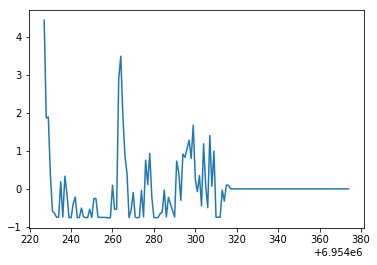

In [34]:
train_dataset.df[train_dataset.df.ForecastId == 6152].Value.plot()
plt.show()

In [36]:
idx = 0

for idx in train_dataset.train_f_ids:
    trainval_X_sequences_ar,trainval_X_sequences_meta,trainval_y_sequences,_,_,_ = train_dataset.__produce_idx_one__(forecast_id=idx)
    print(idx,trainval_y_sequences.shape,trainval_X_sequences_ar.shape)

3320 (300, 30) (300, 30)
6152 (30, 30) (30, 30)
6466 (300, 30) (300, 30)
410 (30, 30) (30, 30)
650 (300, 30) (300, 30)
540 (300, 30) (300, 30)
6151 (300, 30) (300, 30)
6964 (300, 30) (300, 30)
3707 (300, 30) (300, 30)
6727 (30, 30) (30, 30)
189 (300, 30) (300, 30)
1905 (300, 30) (300, 30)
3400 (300, 30) (300, 30)
4294 (300, 30) (300, 30)
3399 (30, 30) (30, 30)
2358 (300, 30) (300, 30)
3738 (30, 30) (30, 30)
6462 (300, 30) (300, 30)
5236 (30, 30) (30, 30)
877 (300, 30) (300, 30)
413 (30, 30) (30, 30)
982 (300, 30) (300, 30)
649 (30, 30) (30, 30)
1390 (300, 30) (300, 30)
6011 (30, 30) (30, 30)
4394 (30, 30) (30, 30)
5233 (300, 30) (300, 30)
1534 (300, 30) (300, 30)
6008 (300, 30) (300, 30)
6972 (300, 30) (300, 30)
2925 (300, 30) (300, 30)
1319 (30, 30) (30, 30)
4323 (300, 30) (300, 30)
2977 (300, 30) (300, 30)
4270 (300, 30) (300, 30)
547 (30, 30) (30, 30)
5229 (300, 30) (300, 30)
5600 (300, 30) (300, 30)
4325 (300, 30) (300, 30)
1 (300, 30) (300, 30)
3 (300, 30) (300, 30)
2926 (30, 30) 

In [22]:
import gc


gc.collect()

2677

In [12]:
model

E2ELSTM_day(
  (hol_emb): Embedding(200, 24)
  (month_emb): Embedding(100, 4)
  (day_emb): Embedding(100, 11)
  (dow_emb): Embedding(100, 3)
  (lstm_meta): LSTM(44, 30, num_layers=2, batch_first=True)
  (lstm_ar): LSTM(1, 30, num_layers=2, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=60, out_features=256)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=256, out_features=256)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU(inplace)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=256, out_features=30)
  )
)

In [200]:
train_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_hour',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'test',
                     split_mode = 'random',
                     predictors = predictors)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,        
    shuffle=False,
    num_workers=1,
    pin_memory=False,
    drop_last=False)


Creating dataset object ...
Normalizing features ...


In [342]:
# key params
lr = 1e-3
start_epoch = 0
epochs = 40
# 16 samples per batch
batch_size = 20
# lstm params
in_sequence_len = 30
out_sequence_len = 30
features_meta_total = 43
features_ar_total = 1
meta_hidden_layer_length = 30
ar_hidden_layer_length = 30
meta_hidden_layers = 3
ar_hidden_layers = 3
lstm_dropout = 0
# MLP model end params
# B x meta_hidden_layer_length || B x ar_hidden_layer_length => classifier_hidden_length => out_sequence_len
classifier_hidden_length = 256

In [343]:
import os

args = type('test', (object,), {})()

args.resume = 'weights/bl_1d_1e2_3lyr_best.pth.tar'
args.evaluate = False

model = E2ELSTM_day(in_sequence_len = in_sequence_len,
                 out_sequence_len = out_sequence_len,
                 features_meta_total = features_meta_total,
                 features_ar_total = features_ar_total,
                 meta_hidden_layer_length = meta_hidden_layer_length,
                 ar_hidden_layer_length = ar_hidden_layer_length,
                 meta_hidden_layers = meta_hidden_layers,
                 ar_hidden_layers = ar_hidden_layers,
                 lstm_dropout =lstm_dropout,
                 classifier_hidden_length = classifier_hidden_length)

# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

=> loading checkpoint 'weights/bl_1d_1e2_3lyr_best.pth.tar'
=> loaded checkpoint 'False' (epoch 80)


In [344]:
model.cuda()

E2ELSTM_day(
  (hol_emb): Embedding(100, 24)
  (month_emb): Embedding(100, 4)
  (day_emb): Embedding(100, 11)
  (dow_emb): Embedding(100, 3)
  (lstm_meta): LSTM(43, 30, num_layers=3, batch_first=True)
  (lstm_ar): LSTM(1, 30, num_layers=3, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=60, out_features=256)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=256, out_features=256)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU(inplace)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=256, out_features=30)
  )
)

In [195]:
pt = pd.pivot_table(data_df[(data_df.ForecastId_type == '1_hour')
                           & (data_df.is_train == 0)],
               index=['ForecastId'],
               columns=['ForecastId_type'],
               values=['obs_id'],
               aggfunc=[len],
               fill_value=0)

In [125]:
len(train_dataset.forecast_ids)

5372

In [379]:
import random
from Utils import WRMSE

stat_cols = ['forecast_id','wrmse_val','r2_val']
stat_df = pd.DataFrame(columns = stat_cols)

predict_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'test',
                     split_mode = 'random',
                     predictors = predictors)


predict_dataset_wrmse = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'evaluate_wrmse',
                     split_mode = 'random',
                     predictors = predictors)

# switch to evaluate mode
model.eval()

Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


E2ELSTM_day(
  (hol_emb): Embedding(100, 24)
  (month_emb): Embedding(100, 4)
  (day_emb): Embedding(100, 11)
  (dow_emb): Embedding(100, 3)
  (lstm_meta): LSTM(43, 30, num_layers=3, batch_first=True)
  (lstm_ar): LSTM(1, 30, num_layers=3, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=60, out_features=256)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=256, out_features=256)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU(inplace)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=256, out_features=30)
  )
)

In [427]:
predict_dataset.df[(predict_dataset.df.ForecastId == forecast_id)
                       & (predict_dataset.df.is_train == 0)].iloc[-30:][predictors].values.shape

(30, 8)

In [432]:
truncate_len.shape

torch.Size([1, 58, 7])

0.190340586872203 -0.36736267021135105


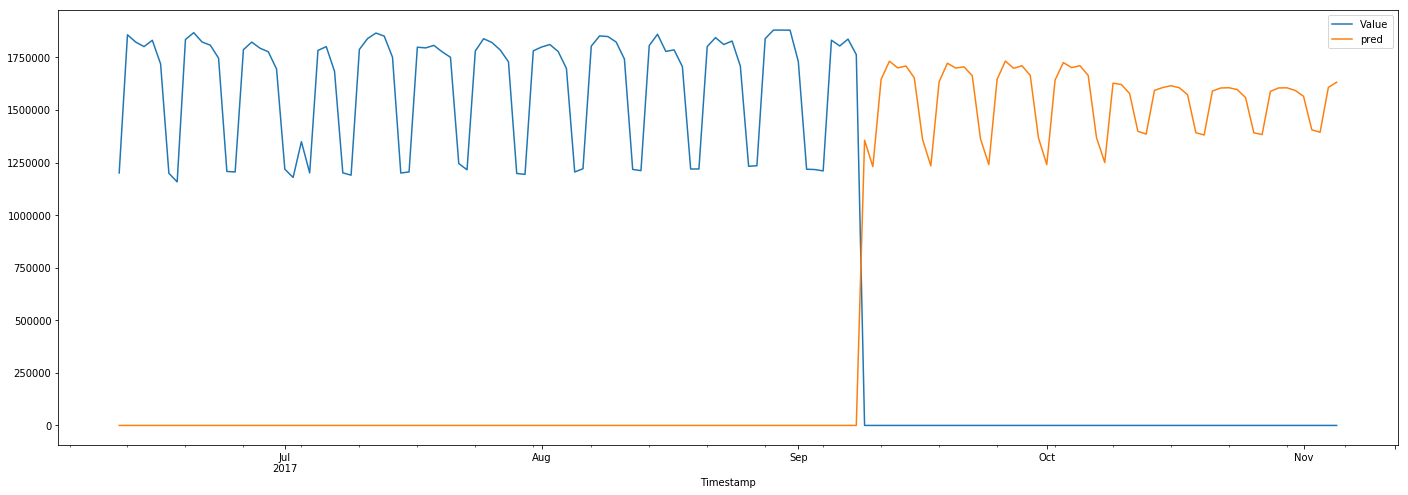

In [460]:
forecast_id_test = predict_dataset_wrmse.forecast_ids[random.randint(0,len(predict_dataset_wrmse.forecast_ids))]

# forecast loop for 1 day models
for i,forecast_id in enumerate(predict_dataset.forecast_ids):
    forecast_id = forecast_id_test
    i = predict_dataset.forecast_ids.index(forecast_id)
    
    test_X_sequences_meta,test_X_sequences_ar,len_diff = predict_dataset.__getitem__(i)
    
    # into PyTorch format
    test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,8)
    test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    
    
    # transform data from Batch x Window x Etc into Batch x Etc format
    test_X_sequences_ar = test_X_sequences_ar.float()
    test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
    test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

    x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
    x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
    x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

    # compute output
    output = model(x_temp_var,x_meta_var,x_ar_var)    
    output = output[0,:].data.cpu().numpy()
    # predict first 30 time points
    output1 = output
    
    # then predict the remaining points using data we have
    predict_len = predict_dataset.df[(predict_dataset.df.ForecastId == forecast_id)
                       & (predict_dataset.df.is_train == 0)].shape[0]
    remaining_len = predict_len - len(output1)
    
    # use our preds as AR values for final prediction
    # predict more values
    test_X_sequences_ar = output1
    test_X_sequences_meta = predict_dataset.df[(predict_dataset.df.ForecastId == forecast_id)
                                               &(predict_dataset.df.is_train == 0)].iloc[-len(output1) * 2:][predictors].values
    test_X_sequences_meta = test_X_sequences_meta.copy()
    # into PyTorch format
    test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,8)
    test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    
    
    # transform data from Batch x Window x Etc into Batch x Etc format
    test_X_sequences_ar = test_X_sequences_ar.float()
    test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
    test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

    x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
    x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
    x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)    
    
    # compute output
    output = model(x_temp_var,x_meta_var,x_ar_var)    
    output = output[0,:].data.cpu().numpy()
    # predict first 30 time points
    output2 = output    
    
    truncate_len = predict_len - len(output1) - len(output2)
    final_output = np.hstack((output1,output2[-truncate_len:]))
    
    final_output = final_output * predict_dataset.std_dict[forecast_id] + predict_dataset.mean_dict[forecast_id]
    submission_df.loc[submission_df.ForecastId == forecast_id_test, 'Value'] =  final_output    
    
    break
    
import matplotlib.pyplot as plt

plot_df = data_df[data_df.ForecastId == forecast_id]
plot_df['pred'] = 0
plot_df.loc[plot_df.is_train == 0, 'pred'] = final_output
plot_df.Timestamp = pd.to_datetime(plot_df.Timestamp)
     

# forecast loop - evaluate on the last sequence on trainval dataset
for i,forecast_id in enumerate(predict_dataset_wrmse.forecast_ids):
    forecast_id = forecast_id_test
    i = predict_dataset_wrmse.forecast_ids.index(forecast_id)
    
    X_sequences_ar,X_sequences_meta,y_sequences = predict_dataset_wrmse.__getitem__(i)        
    X_sequences_meta = torch.from_numpy(X_sequences_meta).view(1,-1,8)
    X_sequences_ar = torch.from_numpy(X_sequences_ar).view(1,-1,1)

    y_true = y_sequences.reshape(-1) * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

    # transform data from Batch x Window x Etc into Batch x Etc format
    X_sequences_ar = X_sequences_ar.float()
    X_sequences_temp = X_sequences_meta[:,:,0:1].float()
    X_sequences_meta = X_sequences_meta[:,:,1:].long()

    x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
    x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
    x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

    # compute output
    output = model(x_temp_var,x_meta_var,x_ar_var)    
    output = output[0,:].data.cpu().numpy()
    
    output = output * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

    wrmse_val = WRMSE(y_true, output)
    r2_score_val = metrics.r2_score(y_true, output)
    stat_df = stat_df.append(pd.DataFrame([dict(zip(stat_cols,[forecast_id,r2_score_val,wrmse_val]))]))
    
    break    
    
plot_df[['Value','Timestamp','pred']].plot(x='Timestamp',figsize=(24, 8 * 1))
print(rmse_val,r2_score_val)
plt.show()  


In [469]:
len(submit_zeroes) + len(submit_averages) + len(train_forecast_ids)

6974

In [473]:
data_df[data_df.ForecastId == submit_averages[0]].Value.mean()

2888.5322610477847

In [487]:
print('Submitting averages ... ')
with tqdm.tqdm(total=len(submit_averages)) as pbar:
    for forecast_id in submit_averages:
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] = data_df[data_df.ForecastId == forecast_id].mean()
        pbar.update(1)
        
print('Submitting zeroes ... ')
with tqdm.tqdm(total=len(submit_zeroes)) as pbar:
    for forecast_id in submit_zeroes:
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] = 0
        pbar.update(1)        

Submitting averages ... 


NameError: name 'wait' is not defined

100%|██████████| 10/10 [00:00<00:00, 161.36it/s]

Submitting zeroes ... 


In [462]:
len(predict_dataset.forecast_ids)

224

In [443]:
final_output[0]

1981285.8

0.190340586872203 -0.6055050035464371


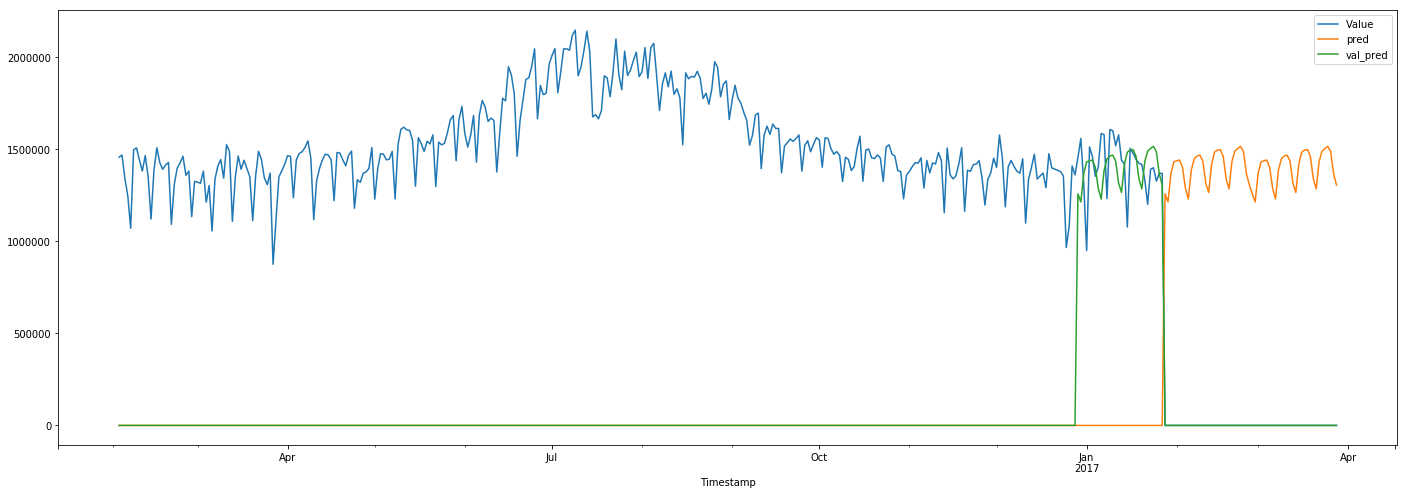

In [412]:
forecast_id_test = predict_dataset_wrmse.forecast_ids[random.randint(0,len(predict_dataset_wrmse.forecast_ids))]

# forecast loop for 15min and 1hour models
for i,forecast_id in enumerate(predict_dataset.forecast_ids):
    forecast_id = forecast_id_test
    i = predict_dataset.forecast_ids.index(forecast_id)
    
    test_X_sequences_meta,test_X_sequences_ar,len_diff = predict_dataset.__getitem__(i)
    
    # into PyTorch format
    test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,8)
    test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    
    
    # transform data from Batch x Window x Etc into Batch x Etc format
    test_X_sequences_ar = test_X_sequences_ar.float()
    test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
    test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

    x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
    x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
    x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

    # compute output
    output = model(x_temp_var,x_meta_var,x_ar_var)    
    output = output[0,:].data.cpu().numpy()
    # only the necessary length
    output1 = output[-len_diff:]
    
    
    
    output = output * predict_dataset.std_dict[forecast_id] + predict_dataset.mean_dict[forecast_id]
    submission_df.loc[submission_df.ForecastId == forecast_id_test, 'Value'] =  np.hstack((output,output))    
    
    break
    
import matplotlib.pyplot as plt

plot_df = data_df[data_df.ForecastId == forecast_id]
plot_df['pred'] = 0
plot_df.loc[plot_df.is_train == 0, 'pred'] = np.hstack((output,output))  
plot_df.Timestamp = pd.to_datetime(plot_df.Timestamp)
     

# forecast loop - evaluate on the last sequence on trainval dataset
for i,forecast_id in enumerate(predict_dataset_wrmse.forecast_ids):
    forecast_id = forecast_id_test
    i = predict_dataset_wrmse.forecast_ids.index(forecast_id)
    
    X_sequences_ar,X_sequences_meta,y_sequences = predict_dataset_wrmse.__getitem__(i)        
    X_sequences_meta = torch.from_numpy(X_sequences_meta).view(1,-1,8)
    X_sequences_ar = torch.from_numpy(X_sequences_ar).view(1,-1,1)

    y_true = y_sequences.reshape(-1) * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

    # transform data from Batch x Window x Etc into Batch x Etc format
    X_sequences_ar = X_sequences_ar.float()
    X_sequences_temp = X_sequences_meta[:,:,0:1].float()
    X_sequences_meta = X_sequences_meta[:,:,1:].long()

    x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
    x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
    x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

    # compute output
    output = model(x_temp_var,x_meta_var,x_ar_var)    
    output = output[0,:].data.cpu().numpy()
    
    output = output * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

    wrmse_val = WRMSE(y_true, output)
    r2_score_val = metrics.r2_score(y_true, output)
    stat_df = stat_df.append(pd.DataFrame([dict(zip(stat_cols,[forecast_id,r2_score_val,wrmse_val]))]))
    
    break    
    
plot_df['val_pred'] = 0
plot_df.loc[plot_df.index[-plot_df[plot_df.is_train==0].shape[0]-30:-plot_df[plot_df.is_train==0].shape[0]],'val_pred'] = output

plot_df[['Value','Timestamp','pred','val_pred']].plot(x='Timestamp',figsize=(24, 8 * 1))
print(rmse_val,r2_score_val)
plt.show()  




In [381]:
submission_df.loc[submission_df.ForecastId == forecast_id_test, 'Value'].shape

(58,)

In [384]:
np.hstack((output,output)).shape

(60,)

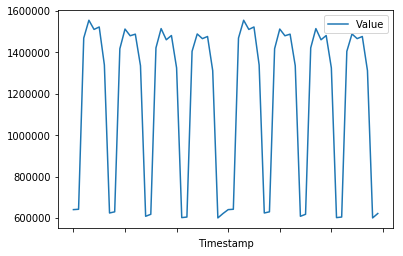

In [383]:
submission_df.loc[submission_df.ForecastId == forecast_id_test][['Value','Timestamp']].plot(x='Timestamp')

In [215]:
forecast_id

647

In [141]:
output.sum()

348810.88

In [134]:
output.shape

(192,)

In [137]:
plot_df.loc[plot_df.is_train == 0, 'pred'].shape

(192,)

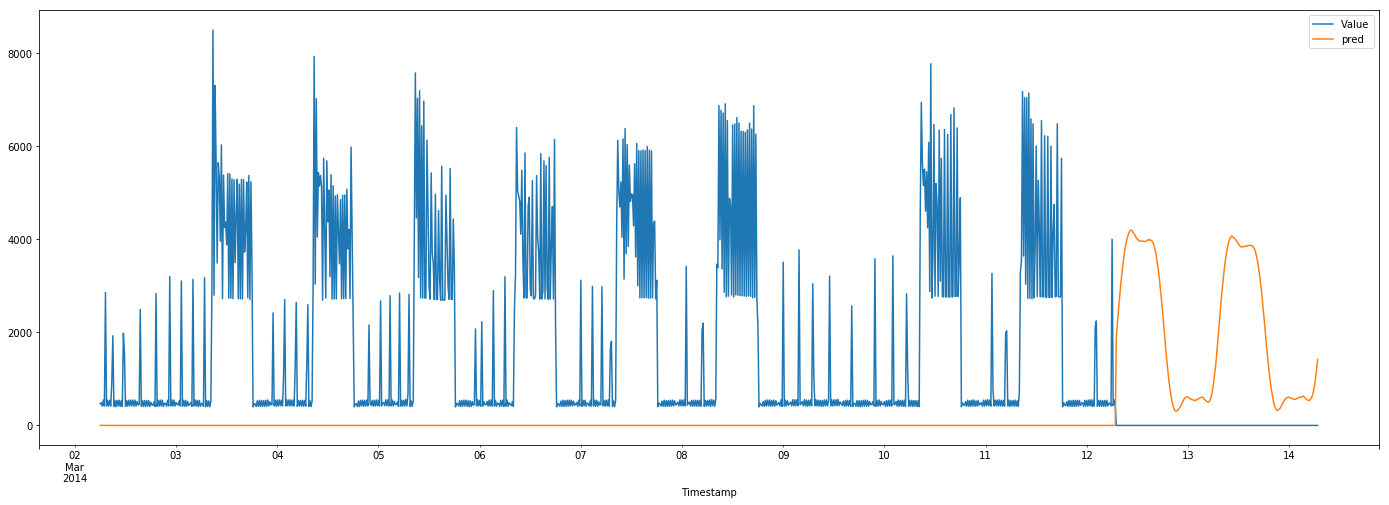

In [91]:
output.shape

(192,)

In [36]:
len(train_loader)

269

In [31]:
# PyTorch training loop sugar

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features

model = E2ELSTM_day(in_sequence_len = in_sequence_len,
                 out_sequence_len = out_sequence_len,
                 features_meta_total = features_meta_total,
                 features_ar_total = features_ar_total,
                 meta_hidden_layer_length = meta_hidden_layer_length,
                 ar_hidden_layer_length = ar_hidden_layer_length,
                 meta_hidden_layers = meta_hidden_layers,
                 ar_hidden_layers = ar_hidden_layers,
                 lstm_dropout =lstm_dropout,
                 classifier_hidden_length = classifier_hidden_length)

# model.cuda()

train_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'train',
                     split_mode = 'random',
                     predictors = predictors)

val_dataset = S2SDataset(df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))],
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'val',
                     split_mode = 'random',
                     predictors = predictors)  

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,        
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,        
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=False)

criterion = nn.MSELoss().cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = lr)

scheduler = ReduceLROnPlateau(optimizer = optimizer,
                                          mode = 'min',
                                          factor = 0.1,
                                          patience = 4,
                                          verbose = True,
                                          threshold = 1e-3,
                                          min_lr = 1e-7
                                          )

Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


In [11]:
train_dataset.df[train_dataset.df.ForecastId_type == '1_day'].Holiday.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71])

In [32]:
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(start_epoch, epochs):
        # train for one epoch
        train_loss = train(train_loader, model, criterion, optimizer, epoch)
        # evaluate on validation set
        val_loss = validate(val_loader, model, criterion)
        scheduler.step(val_loss)
        pbar.set_description('Epoch [{0}/{1}]'.format(str(epoch).zfill(3),str(epochs).zfill(3)), refresh=False)
        pbar.set_postfix(train_loss=train_loss, val_loss=val_loss, refresh=False)
        pbar.update(1)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/9]	Loss 0.9040 (0.9040)	
Test: [0/3]	Loss 0.8871 (0.8871)	


Epoch [000/040]:   2%|▎         | 1/40 [00:04<03:01,  4.66s/it, train_loss=0.946, val_loss=0.923]

Epoch: [1][0/9]	Loss 0.7825 (0.7825)	
Test: [0/3]	Loss 0.9737 (0.9737)	


Epoch [001/040]:   5%|▌         | 2/40 [00:09<02:57,  4.66s/it, train_loss=0.862, val_loss=0.93] 

Epoch: [2][0/9]	Loss 0.7229 (0.7229)	
Test: [0/3]	Loss 0.9448 (0.9448)	


Epoch [002/040]:   8%|▊         | 3/40 [00:13<02:47,  4.52s/it, train_loss=0.826, val_loss=0.941]

Epoch: [3][0/9]	Loss 0.6982 (0.6982)	
Test: [0/3]	Loss 0.7985 (0.7985)	


Epoch [003/040]:  10%|█         | 4/40 [00:17<02:41,  4.48s/it, train_loss=0.806, val_loss=0.889]

Epoch: [4][0/9]	Loss 0.6933 (0.6933)	
Test: [0/3]	Loss 0.8713 (0.8713)	


Epoch [004/040]:  12%|█▎        | 5/40 [00:22<02:35,  4.43s/it, train_loss=0.791, val_loss=0.865]

Epoch: [5][0/9]	Loss 0.6720 (0.6720)	
Test: [0/3]	Loss 0.9068 (0.9068)	


Epoch [005/040]:  15%|█▌        | 6/40 [00:26<02:29,  4.39s/it, train_loss=0.771, val_loss=0.857]

Epoch: [6][0/9]	Loss 0.6638 (0.6638)	
Test: [0/3]	Loss 0.9465 (0.9465)	


Epoch [006/040]:  18%|█▊        | 7/40 [00:30<02:22,  4.32s/it, train_loss=0.755, val_loss=0.822]

Epoch: [7][0/9]	Loss 0.6499 (0.6499)	
Test: [0/3]	Loss 0.6874 (0.6874)	


Epoch [007/040]:  20%|██        | 8/40 [00:34<02:16,  4.27s/it, train_loss=0.739, val_loss=0.777]

Epoch: [8][0/9]	Loss 0.6413 (0.6413)	
Test: [0/3]	Loss 0.7401 (0.7401)	


Epoch [008/040]:  22%|██▎       | 9/40 [00:39<02:13,  4.30s/it, train_loss=0.724, val_loss=0.78] 

Epoch: [9][0/9]	Loss 0.6309 (0.6309)	
Test: [0/3]	Loss 0.8522 (0.8522)	


Epoch [009/040]:  25%|██▌       | 10/40 [00:43<02:08,  4.29s/it, train_loss=0.709, val_loss=0.719]

Test: [0/3]	Loss 0.5865 (0.5865)	


Epoch [030/040]:  78%|███████▊  | 31/40 [02:13<00:39,  4.44s/it, train_loss=0.508, val_loss=0.555]

Epoch: [31][0/9]	Loss 0.4544 (0.4544)	
Test: [0/3]	Loss 0.5124 (0.5124)	


Epoch [031/040]:  80%|████████  | 32/40 [02:18<00:35,  4.44s/it, train_loss=0.506, val_loss=0.587]

Epoch: [32][0/9]	Loss 0.4609 (0.4609)	
Test: [0/3]	Loss 0.5786 (0.5786)	


Epoch [032/040]:  82%|████████▎ | 33/40 [02:22<00:30,  4.42s/it, train_loss=0.511, val_loss=0.604]

Epoch: [33][0/9]	Loss 0.4545 (0.4545)	
Test: [0/3]	Loss 0.5655 (0.5655)	


Epoch [033/040]:  85%|████████▌ | 34/40 [02:26<00:26,  4.35s/it, train_loss=0.509, val_loss=0.571]

Epoch: [34][0/9]	Loss 0.4491 (0.4491)	
Test: [0/3]	Loss 0.5753 (0.5753)	


Epoch [034/040]:  88%|████████▊ | 35/40 [02:30<00:21,  4.27s/it, train_loss=0.508, val_loss=0.573]

Epoch: [35][0/9]	Loss 0.4531 (0.4531)	
Test: [0/3]	Loss 0.5886 (0.5886)	


Epoch [035/040]:  90%|█████████ | 36/40 [02:35<00:17,  4.29s/it, train_loss=0.508, val_loss=0.58] 

Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch: [36][0/9]	Loss 0.4563 (0.4563)	
Test: [0/3]	Loss 0.7074 (0.7074)	


Epoch [036/040]:  92%|█████████▎| 37/40 [02:39<00:13,  4.35s/it, train_loss=0.503, val_loss=0.558]

Epoch: [37][0/9]	Loss 0.4569 (0.4569)	
Test: [0/3]	Loss 0.5414 (0.5414)	


Epoch [037/040]:  95%|█████████▌| 38/40 [02:43<00:08,  4.32s/it, train_loss=0.506, val_loss=0.596]

Epoch: [38][0/9]	Loss 0.4483 (0.4483)	
Test: [0/3]	Loss 0.5135 (0.5135)	


Epoch [038/040]:  98%|█████████▊| 39/40 [02:48<00:04,  4.34s/it, train_loss=0.503, val_loss=0.582]

Epoch: [39][0/9]	Loss 0.4438 (0.4438)	
Test: [0/3]	Loss 0.6851 (0.6851)	


Epoch [039/040]: 100%|██████████| 40/40 [02:52<00:00,  4.32s/it, train_loss=0.503, val_loss=0.604]


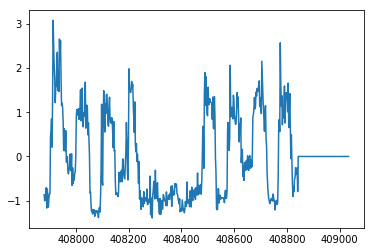

In [39]:
train_dataset.df[train_dataset.df.ForecastId == 359].Value.plot()

In [18]:
a = np.random.randint(1,size=(1,192))

In [ ]:
np.vstack([a] * 16)

In [22]:
list(range(0,16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [21]:
np.vstack([a] * 16).shape

(16, 192)

In [15]:
x1.shape,x2.shape,y.shape

((64, 192), (64, 384, 8), (64, 192))

In [47]:
x2[idx,0].shape

(8,)

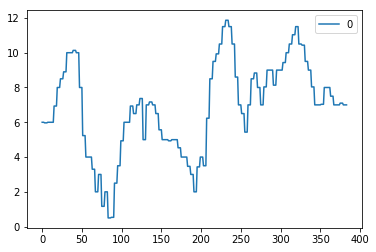

In [48]:
import matplotlib.pyplot as plt
idx = 10
plot_df = pd.DataFrame(list(x2[idx,:,0]))
plot_df.plot()
plt.show()

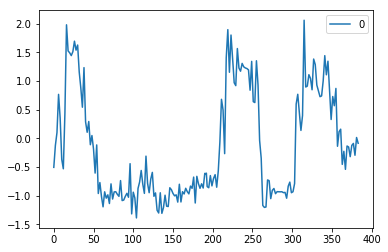

In [35]:
import matplotlib.pyplot as plt
idx = 38
plot_df = pd.DataFrame(list(x1[idx,:])+list(y[idx+10,:]))
plot_df.plot()
plt.show()

In [ ]:
def save_checkpoint(state, is_best, filename, best_filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_filename)



# Debug submissions

In [20]:
# Custom tensorboard logging
from TbLogger import Logger

import os
import time
import tqdm
import shutil
import argparse
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import  metrics
 
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period,preprocess_seq2seq,interpolate

# torch imports
import torch
import torch.optim
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau,MultiStepLR

# custom classes
from SDataset import S2SDataset
from ELstm import E2ELSTM,WMSELoss,E2ELSTM_day

import pandas as pd
import numpy as np
from math import sqrt

from Utils import WRMSE

LOGNUMBER = 'e2e_seq2seq_bl'



In [2]:
def preprocess_data():
    print('Starting the ETL process')

    start_time = time.time()
    df_train,df_sub = ETL_emb()
    test_lengths = count_test_period(df_sub)
    elapsed_time = time.time() - start_time 

    print('Time taken to complete the ETL process {}'.format(elapsed_time))

    forecast_ids = list(test_lengths.keys())
    site_ids = list(df_sub.SiteId.unique())

    # suppress pandas warnings
    # do not do this in production!
    pd.set_option('mode.chained_assignment', None)

    data_df = preprocess_seq2seq(df_train,df_sub)
    # reset index to make sure we do not have double indexes and for easier indexing
    data_df = data_df.reset_index()
    del data_df['index']

    # leave only the first holiday
    data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
    data_df = data_df.reset_index()
    del data_df['index']
    # fill days wo holidays with -1
    data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

    data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages = interpolate(data_df)
    
    return data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages

In [3]:
# preprocess data / ETL / interpolation / data curation
data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages = preprocess_data()

best_1d_model = 'weights/bl_1d_1e2_best.pth.tar'
best_1h_model = 'weights/bl_1h_1e2_best.pth.tar'
best_15m_model = 'weights/bl_15m_3lyr_best.pth.tar'

model_1d = E2ELSTM_day(in_sequence_len = 30,
                 out_sequence_len = 30,
                 features_meta_total = 43,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 30,
                 ar_hidden_layer_length = 30,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 2,
                 lstm_dropout = 0,
                 classifier_hidden_length = 256)

model_1h = E2ELSTM(in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_meta_total = 72,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 192,
                 ar_hidden_layer_length = 192,
                 meta_hidden_layers = 2,
                 ar_hidden_layers = 2,
                 lstm_dropout = 0,
                 classifier_hidden_length = 512)

model_15m = E2ELSTM(in_sequence_len = 192,
                 out_sequence_len = 192,
                 features_meta_total = 72,
                 features_ar_total = 1,
                 meta_hidden_layer_length = 192,
                 ar_hidden_layer_length = 192,
                 meta_hidden_layers = 3,
                 ar_hidden_layers = 3,
                 lstm_dropout = 0,
                 classifier_hidden_length = 512)   

checkpoint = torch.load(best_1d_model)
model_1d.load_state_dict(checkpoint['state_dict'])
print("model_1d => loaded checkpoint (epoch {})".format(checkpoint['epoch']))

checkpoint = torch.load(best_1h_model)
model_1h.load_state_dict(checkpoint['state_dict'])
print("model_1h => loaded checkpoint (epoch {})".format(checkpoint['epoch']))

checkpoint = torch.load(best_15m_model)
model_15m.load_state_dict(checkpoint['state_dict'])
print("model_15m => loaded checkpoint (epoch {})".format(checkpoint['epoch']))    


submission_df = pd.read_csv('../data/forecast/submission_format.csv')
submission_df = submission_df.set_index('obs_id')

model_1d.cuda()
model_1h.cuda()
model_15m.cuda()
model_1d.eval()
model_1h.eval()
model_15m.eval()    

stat_cols = ['forecast_id','wrmse_val','r2_val']
stat_df = pd.DataFrame(columns = stat_cols)

# select only series we marked as trainable
# negation is for speed only
trainable_df = data_df[(~data_df.ForecastId.isin(list(set(data_df.ForecastId.unique()) - set(train_forecast_ids))))]    

Starting the ETL process
Time taken to complete the ETL process 164.21347427368164


 17%|█▋        | 1/6 [00:00<00:00,  7.18it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


model_1d => loaded checkpoint (epoch 51)
model_1h => loaded checkpoint (epoch 71)
model_15m => loaded checkpoint (epoch 76)


In [26]:
print('Predicting for 1 day series ...')

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['month','day','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features
        
predict_dataset = S2SDataset(df = trainable_df,
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'test',
                     split_mode = 'random',
                     predictors = predictors)

predict_dataset_wrmse = S2SDataset(df = trainable_df,
                     series_type = '1_day',
                     in_sequence_len = 30,
                     out_sequence_len = 30,
                     target = 'Value',
                     mode = 'evaluate_wrmse',
                     split_mode = 'random',
                     predictors = predictors)    

print('Dataset length is {}'.format(len(predict_dataset.forecast_ids)))

with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar:    
    for i,forecast_id in enumerate(predict_dataset.forecast_ids):
        i = predict_dataset.forecast_ids.index(forecast_id)

        test_X_sequences_meta,test_X_sequences_ar,len_diff = predict_dataset.__getitem__(i)

        # into PyTorch format
        test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,5)
        test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    

        # transform data from Batch x Window x Etc into Batch x Etc format
        test_X_sequences_ar = test_X_sequences_ar.float()
        test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
        test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_1d(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()
        # predict first 30 time points
        output1 = output

        # then predict the remaining points using data we have
        predict_len = predict_dataset.df[(predict_dataset.df.ForecastId == forecast_id)
                           & (predict_dataset.df.is_train == 0)].shape[0]
        remaining_len = predict_len - len(output1)

        # use our preds as AR values for final prediction
        # predict more values
        test_X_sequences_ar = output1
        test_X_sequences_meta = predict_dataset.df[(predict_dataset.df.ForecastId == forecast_id)
                                                   &(predict_dataset.df.is_train == 0)].iloc[-len(output1) * 2:][predictors].values
        test_X_sequences_meta = test_X_sequences_meta.copy()
        # into PyTorch format
        test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,5)
        test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    

        # transform data from Batch x Window x Etc into Batch x Etc format
        test_X_sequences_ar = test_X_sequences_ar.float()
        test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
        test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)    

        # compute output
        output = model_1d(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()
        # predict first 30 time points
        output2 = output    

        truncate_len = predict_len - len(output1) - len(output2)
        final_output = np.hstack((output1,output2[-truncate_len:]))

        final_output = final_output * predict_dataset.std_dict[forecast_id] + predict_dataset.mean_dict[forecast_id]
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] =  final_output    

        pbar.update(1)

# forecast loop - evaluate on the last sequence on trainval dataset
with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar: 
    for i,forecast_id in enumerate(predict_dataset_wrmse.forecast_ids):
        i = predict_dataset_wrmse.forecast_ids.index(forecast_id)

        X_sequences_ar,X_sequences_meta,y_sequences = predict_dataset_wrmse.__getitem__(i)        
        X_sequences_meta = torch.from_numpy(X_sequences_meta).view(1,-1,5)
        X_sequences_ar = torch.from_numpy(X_sequences_ar).view(1,-1,1)

        y_true = y_sequences.reshape(-1) * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_ar = X_sequences_ar.float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_1d(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()

        output = output * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        wrmse_val = WRMSE(y_true, output)
        r2_score_val = metrics.r2_score(y_true, output)
        stat_df = stat_df.append(pd.DataFrame([dict(zip(stat_cols,[forecast_id,r2_score_val,wrmse_val]))]))

        pbar.update(1)    

print('Predicting for 1 hour series ...')  

temp_features = ['Temperature']
hol_emb_features = ['Holiday']
time_emb_features = ['year', 'month', 'day', 'hour', 'minute','dow']
target = ['Value']
predictors = temp_features + hol_emb_features + time_emb_features

predict_dataset = S2SDataset(df = trainable_df,
                     series_type = '1_hour',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'test',
                     split_mode = 'random',
                     predictors = predictors)

predict_dataset_wrmse = S2SDataset(df = trainable_df,
                     series_type = '1_hour',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'evaluate_wrmse',
                     split_mode = 'random',
                     predictors = predictors)                      

print('Dataset length is {}'.format(len(predict_dataset.forecast_ids)))

with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar:
    for i,forecast_id in enumerate(predict_dataset.forecast_ids):
        i = predict_dataset.forecast_ids.index(forecast_id)

        test_X_sequences_meta,test_X_sequences_ar,len_diff = predict_dataset.__getitem__(i)

        # into PyTorch format
        test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,8)
        test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    

        # transform data from Batch x Window x Etc into Batch x Etc format
        test_X_sequences_ar = test_X_sequences_ar.float()
        test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
        test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_1h(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()
        # only the necessary length
        output = output[-len_diff:]

        output = output * predict_dataset.std_dict[forecast_id] + predict_dataset.mean_dict[forecast_id]
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] =  output 
        pbar.update(1)

with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar:
    for i,forecast_id in enumerate(predict_dataset_wrmse.forecast_ids):
        i = predict_dataset_wrmse.forecast_ids.index(forecast_id)

        X_sequences_ar,X_sequences_meta,y_sequences = predict_dataset_wrmse.__getitem__(i)        
        X_sequences_meta = torch.from_numpy(X_sequences_meta).view(1,-1,8)
        X_sequences_ar = torch.from_numpy(X_sequences_ar).view(1,-1,1)

        y_true = y_sequences.reshape(-1) * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_ar = X_sequences_ar.float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_1h(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()

        output = output * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        wrmse_val = WRMSE(y_true, output)
        r2_score_val = metrics.r2_score(y_true, output)
        stat_df = stat_df.append(pd.DataFrame([dict(zip(stat_cols,[forecast_id,r2_score_val,wrmse_val]))]))
        pbar.update(1)

print('Predicting for 15 min series ...')                       

predict_dataset = S2SDataset(df = trainable_df,
                     series_type = '15_mins',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'test',
                     split_mode = 'random',
                     predictors = predictors)

predict_dataset_wrmse = S2SDataset(df = trainable_df,
                     series_type = '15_mins',
                     in_sequence_len = 192,
                     out_sequence_len = 192,
                     target = 'Value',
                     mode = 'evaluate_wrmse',
                     split_mode = 'random',
                     predictors = predictors)                      

print('Dataset length is {}'.format(len(predict_dataset.forecast_ids)))

with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar:
    for i,forecast_id in enumerate(predict_dataset.forecast_ids):
        i = predict_dataset.forecast_ids.index(forecast_id)

        test_X_sequences_meta,test_X_sequences_ar,len_diff = predict_dataset.__getitem__(i)

        # into PyTorch format
        test_X_sequences_meta = torch.from_numpy(test_X_sequences_meta).view(1,-1,8)
        test_X_sequences_ar = torch.from_numpy(test_X_sequences_ar).view(1,-1,1)    

        # transform data from Batch x Window x Etc into Batch x Etc format
        test_X_sequences_ar = test_X_sequences_ar.float()
        test_X_sequences_temp = test_X_sequences_meta[:,:,0:1].float()
        test_X_sequences_meta = test_X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_15m(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()
        # only the necessary length
        output = output[-len_diff:]

        output = output * predict_dataset.std_dict[forecast_id] + predict_dataset.mean_dict[forecast_id]
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] =  output 
        pbar.update(1)

with tqdm.tqdm(total=len(predict_dataset.forecast_ids)) as pbar:
    for i,forecast_id in enumerate(predict_dataset_wrmse.forecast_ids):
        i = predict_dataset_wrmse.forecast_ids.index(forecast_id)

        X_sequences_ar,X_sequences_meta,y_sequences = predict_dataset_wrmse.__getitem__(i)        
        X_sequences_meta = torch.from_numpy(X_sequences_meta).view(1,-1,8)
        X_sequences_ar = torch.from_numpy(X_sequences_ar).view(1,-1,1)

        y_true = y_sequences.reshape(-1) * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        # transform data from Batch x Window x Etc into Batch x Etc format
        X_sequences_ar = X_sequences_ar.float()
        X_sequences_temp = X_sequences_meta[:,:,0:1].float()
        X_sequences_meta = X_sequences_meta[:,:,1:].long()

        x_temp_var = torch.autograd.Variable(test_X_sequences_temp).cuda(async=True)
        x_meta_var = torch.autograd.Variable(test_X_sequences_meta).cuda(async=True)
        x_ar_var = torch.autograd.Variable(test_X_sequences_ar).cuda(async=True)

        # compute output
        output = model_15m(x_temp_var,x_meta_var,x_ar_var)    
        output = output[0,:].data.cpu().numpy()

        output = output * predict_dataset_wrmse.std_dict[forecast_id] + predict_dataset_wrmse.mean_dict[forecast_id]

        wrmse_val = WRMSE(y_true, output)
        r2_score_val = metrics.r2_score(y_true, output)
        stat_df = stat_df.append(pd.DataFrame([dict(zip(stat_cols,[forecast_id,r2_score_val,wrmse_val]))]))
        pbar.update(1)                   

# submit zeroes and averages
print('Submitting averages ... ')
with tqdm.tqdm(total=len(submit_averages)) as pbar:
    for forecast_id in submit_averages:
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] = data_df[data_df.ForecastId == forecast_id].mean()
        pbar.update(1)

print('Submitting zeroes ... ')
with tqdm.tqdm(total=len(submit_zeroes)) as pbar:
    for forecast_id in submit_zeroes:
        submission_df.loc[submission_df.ForecastId == forecast_id, 'Value'] = 0
        pbar.update(1)

Predicting for 1 day series ...
Creating dataset object ...
Normalizing features ...
Creating dataset object ...


  2%|▏         | 4/224 [00:00<00:06, 35.00it/s]

Normalizing features ...
Dataset length is 224


100%|██████████| 224/224 [00:02<00:00, 92.00it/s]


Predicting for 1 hour series ...
Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


  0%|          | 2/1294 [00:00<01:13, 17.56it/s]

Dataset length is 1294


100%|██████████| 1294/1294 [01:07<00:00, 19.52it/s]


Predicting for 15 min series ...
Creating dataset object ...
Normalizing features ...
Creating dataset object ...
Normalizing features ...


  0%|          | 2/5372 [00:00<05:57, 15.02it/s]

Dataset length is 5372


  4%|▍         | 3/74 [00:00<00:03, 21.91it/s]

Submitting averages ... 


100%|██████████| 10/10 [00:00<00:00, 159.06it/s]

Submitting zeroes ... 


In [28]:
5372 + 1294 + 224

6890

In [33]:
stat_df.head()

,forecast_id,r2_val,wrmse_val
0,1,0.434941,-1.210618
0,2,0.472015,-0.743531
0,3,1.865952,-2.231367
0,4,0.639187,-0.418527
0,41,0.518941,0.048318


In [49]:
stat_df.loc[stat_df.wrmse_val<0,'wrmse_val'] = -1

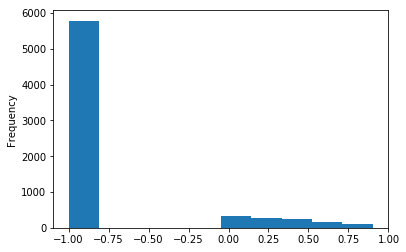

In [50]:
import matplotlib.pyplot as plt
stat_df[stat_df.wrmse_val>-2].drop_duplicates().wrmse_val.plot(kind='hist')
plt.show()

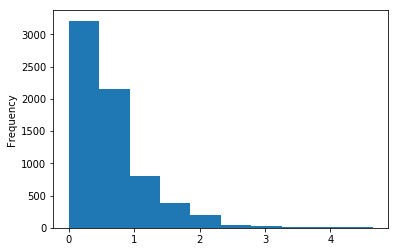

In [45]:
import matplotlib.pyplot as plt
stat_df[stat_df.r2_val<5].drop_duplicates().r2_val.plot(kind='hist')
plt.show()

In [51]:
stat_df.r2_val.describe()

count    7.338000e+03
mean     7.850621e-01
std      3.668791e+00
min      1.651082e-10
25%      2.533180e-01
50%      4.837395e-01
75%      8.379434e-01
max      1.884769e+02
Name: r2_val, dtype: float64

In [35]:
stat_df[stat_df.forecast_id == 6966]

,forecast_id,r2_val,wrmse_val
0,6966,0.036638,-6.832434
0,6966,0.036638,-6.832434
0,6966,0.036638,-6.832434


In [34]:
stat_df.groupby(['forecast_id'])['r2_val'].count()

forecast_id
1       3
2       3
3       3
4       3
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
30      1
       ..
6945    1
6946    1
6947    1
6948    1
6949    1
6950    1
6951    1
6952    1
6953    1
6954    1
6955    1
6956    1
6957    1
6958    1
6959    1
6960    1
6961    1
6962    3
6963    3
6964    3
6965    3
6966    3
6967    3
6968    3
6969    3
6970    3
6971    3
6972    3
6973    3
6974    1
Name: r2_val, Length: 6890, dtype: int64

In [32]:
len(stat_df.forecast_id.unique())

6890

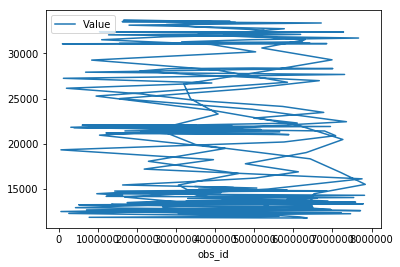

In [71]:
submission_df[submission_df.ForecastId==forecast_id][['Value','Timestamp']].plot(by='Timestamp')

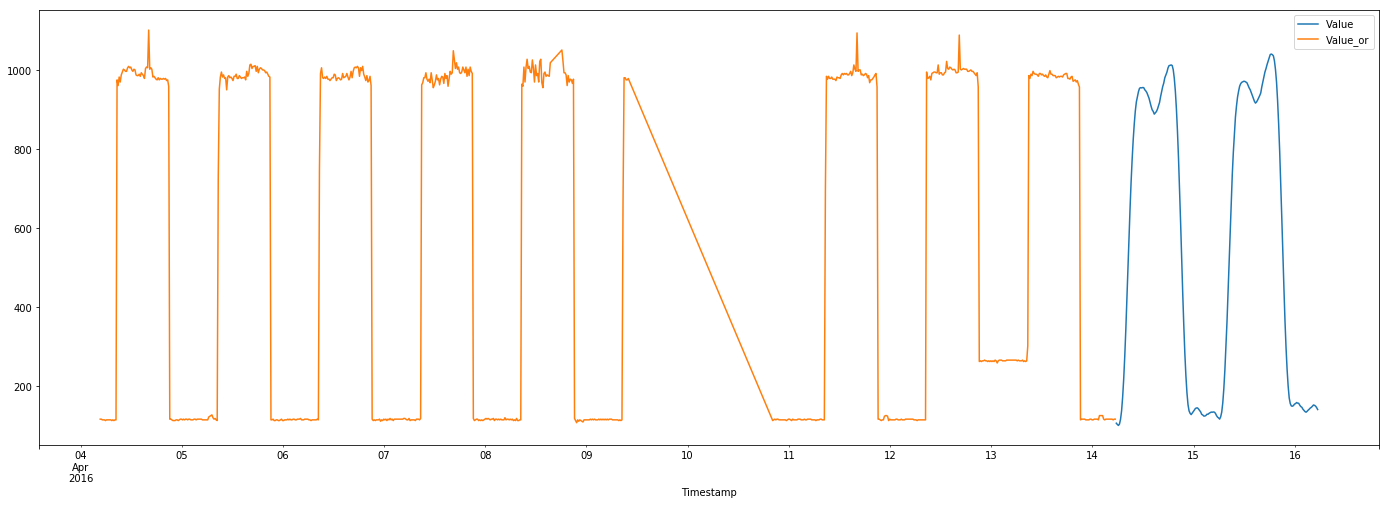

In [136]:
import random
idx = random.randint(0,len(list(submission_df.ForecastId.unique())))
forecast_id = list(submission_df.ForecastId.unique())[idx]

plot_df = data_df[data_df.is_train==1].iloc[:][data_df[data_df.is_train==1].ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']]
plot_df.columns = ['Value_or','Timestamp']

plot_df = plot_df.append(submission_df.iloc[:][submission_df.ForecastId==forecast_id].sort_values(by='Timestamp',ascending=True)[['Value','Timestamp']])

plot_df['Timestamp'] = pd.to_datetime(plot_df['Timestamp'])
plot_df[['Value','Value_or','Timestamp']].plot(x = 'Timestamp',figsize=(24, 8 * 1))

plt.show()

In [115]:
submission_df.shape

(1309176, 4)

In [114]:
stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))

In [113]:
stat_df.to_csv('forest_stats_{}.csv'.format(LOGNUMBER))
submission_df['Value'] = submission_df['Value'].fillna(value=0)
submission_df.to_csv('../submissions/forecast_{}.csv'.format(LOGNUMBER))

In [143]:
submission_df2 = pd.read_csv('../submissions/forecast_8_models_wrmse_train_val_average_or_last.csv')

In [139]:
submission_df.shape

(1309176, 4)

In [144]:
submission_df2.shape

(1309176, 5)

In [147]:
submission_df2 = submission_df2.set_index('obs_id')

In [151]:
submission_df3 = submission_df2
submission_df3.Value = submission_df2.Value/2 + submission_df.Value/2


In [154]:
submission_df3.to_csv('../submissions/blended_lstm_forests.csv')

# Try to feather

In [1]:
# custom utils and random forest scripts
from Utils import ETL_emb, count_test_period,preprocess_seq2seq,interpolate

In [2]:
import time
import pandas as pd 

def preprocess_data():
    print('Starting the ETL process')

    start_time = time.time()
    df_train,df_sub = ETL_emb()
    test_lengths = count_test_period(df_sub)
    elapsed_time = time.time() - start_time 

    print('Time taken to complete the ETL process {}'.format(elapsed_time))

    forecast_ids = list(test_lengths.keys())
    site_ids = list(df_sub.SiteId.unique())

    # suppress pandas warnings
    # do not do this in production!
    pd.set_option('mode.chained_assignment', None)

    submission_df = pd.read_csv('../data/forecast/submission_format.csv')
    submission_df = submission_df.set_index('obs_id')

    data_df = preprocess_seq2seq(df_train,df_sub)
    # reset index to make sure we do not have double indexes and for easier indexing
    data_df = data_df.reset_index()
    del data_df['index']

    # leave only the first holiday
    data_df = data_df[(data_df['obs_id'].shift(+1) != data_df['obs_id'])]
    data_df = data_df.reset_index()
    del data_df['index']
    # fill days wo holidays with -1
    data_df['Holiday'] = data_df['Holiday'].fillna(value=-1)

    data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages = interpolate(data_df)
    
    return data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages

In [3]:
data_df,train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages = preprocess_data()

Starting the ETL process
Time taken to complete the ETL process 186.76800799369812


 17%|█▋        | 1/6 [00:00<00:00,  6.63it/s]

Removing drastic outliers ... 


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


In [8]:
data_df = data_df.reset_index()

In [11]:
!ls -laht ../data/forecast/data_df_feather

-rw-r--r-- 1 keras users 1.5G Mar 17 19:12 ../data/forecast/data_df_feather


In [9]:
data_df.to_feather('../data/forecast/data_df_feather')

In [15]:
data_df.shape

(7858005, 24)

In [14]:
data_df = pd.read_feather('../data/forecast/data_df_feather')

In [17]:
import pickle 

with open('train_forecast_ids.pkl', 'wb') as output:
    pickle.dump(train_forecast_ids, output, pickle.HIGHEST_PROTOCOL)
    
with open('normal_forecast_ids.pkl', 'wb') as output:
    pickle.dump(normal_forecast_ids, output, pickle.HIGHEST_PROTOCOL)
    
with open('linear_interpolation.pkl', 'wb') as output:
    pickle.dump(linear_interpolation, output, pickle.HIGHEST_PROTOCOL)
    
with open('last_window.pkl', 'wb') as output:
    pickle.dump(last_window, output, pickle.HIGHEST_PROTOCOL)
    
with open('submit_zeroes.pkl', 'wb') as output:
    pickle.dump(submit_zeroes, output, pickle.HIGHEST_PROTOCOL)
    
with open('submit_averages.pkl', 'wb') as output:
    pickle.dump(submit_averages, output, pickle.HIGHEST_PROTOCOL)    

In [19]:
import pickle 

# read all pre-calculated objects
data_df = pd.read_feather('../data/forecast/data_df_feather')
with open('train_forecast_ids.pkl', 'rb') as input:
    train_forecast_ids = pickle.load(input)
with open('normal_forecast_ids.pkl', 'rb') as input:
    normal_forecast_ids = pickle.load(input)
with open('linear_interpolation.pkl', 'rb') as input:
    linear_interpolation = pickle.load(input)
with open('last_window.pkl', 'rb') as input:
    last_window = pickle.load(input)
with open('submit_zeroes.pkl', 'rb') as input:
    submit_zeroes = pickle.load(input)
with open('submit_averages.pkl', 'rb') as input:
    submit_averages = pickle.load(input)
  

In [26]:
len(submit_averages)

74

In [ ]:
train_forecast_ids,normal_forecast_ids,linear_interpolation,last_window,submit_zeroes,submit_averages